# Demo Notebook: Flash-Transformer
This notebook demonstrates how to:
1. Install dependencies
2. Download & preprocess data
3. Train the Transformer model with FlashAttention
4. Evaluate on the test set
5. Run a quick inference example.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys, os

In [ ]:
path = '/content/drive/My Drive/flash_transformer/'

In [ ]:
!ls "{path}"

bleu_scores_plot.png	  checkpoints  data	  requirements.txt  scripts  tests
bleu_scores_results.json  config       notebooks  results.json	    src


In [ ]:
%cd "{path}"

/content/drive/My Drive/flash_transformer


In [ ]:
print("Current directory:", os.getcwd())

!ls -R

Current directory: /content/drive/My Drive/flash_transformer
.:
bleu_scores_plot.png	  checkpoints  data	  requirements.txt  scripts  tests
bleu_scores_results.json  config       notebooks  results.json	    src

./checkpoints:
model_epoch_100.pt  model_epoch_193.pt	model_epoch_92.pt    model_step_51500.pt
model_epoch_101.pt  model_epoch_194.pt	model_epoch_93.pt    model_step_52000.pt
model_epoch_102.pt  model_epoch_195.pt	model_epoch_94.pt    model_step_52500.pt
model_epoch_103.pt  model_epoch_196.pt	model_epoch_95.pt    model_step_53000.pt
model_epoch_104.pt  model_epoch_197.pt	model_epoch_96.pt    model_step_53500.pt
model_epoch_105.pt  model_epoch_198.pt	model_epoch_97.pt    model_step_54000.pt
model_epoch_106.pt  model_epoch_199.pt	model_epoch_98.pt    model_step_54500.pt
model_epoch_107.pt  model_epoch_19.pt	model_epoch_99.pt    model_step_55000.pt
model_epoch_108.pt  model_epoch_1.pt	model_epoch_9.pt     model_step_5500.pt
model_epoch_109.pt  model_epoch_200.pt	model_step_10000.p

## 1. Install Dependencies
We'll install everything from `requirements.txt`. In Colab, we can run `%pip install ...` directly.

In [ ]:
!pip install -r requirements.txt

## 2. Data Download & Preprocessing
This will:
- Download a reduced WMT14 (EN–DE) dataset via Hugging Face.
- Train a SentencePiece model.
- Apply BPE tokenization.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

In [ ]:
!bash scripts/preprocess.sh

Saving the dataset (1/1 shards): 100% 45088/45088 [00:00<00:00, 627256.37 examples/s]
Saving the dataset (1/1 shards): 100% 3000/3000 [00:00<00:00, 340170.64 examples/s]
Saving the dataset (1/1 shards): 100% 3003/3003 [00:00<00:00, 320381.92 examples/s]
Download and subset extraction complete!
Preprocessing dataset...
Building combined corpus from training data...
Combined corpus lines written (each line is a single sentence): 90176
Training BPE model...
Training BPE with vocab size=8000...
sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/tokenized/combined.txt --model_prefix=data/tokenized/vocab --vocab_size=8000 --unk_id=0 --pad_id=1 --bos_id=2 --eos_id=3 --user_defined_symbols=[SEP]
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/tokenized/combined.txt
  input_format: 
  model_prefix: data/tokenized/vocab
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_s

## 3. Train the Model
We'll run the `train.sh` script, which calls `src/training/train.py`.
Check `config/config.yaml` to modify hyperparameters such as:
- `max_epochs`
- `batch_size`
- `learning_rate`
- etc.

In [ ]:
!pip install flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.7.3-cp311-cp311-linux_x86_64

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is enabled!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU needed to run x_x.")

GPU is enabled!
Using GPU: NVIDIA L4


In [ ]:
!bash scripts/train.sh

Streaming output truncated to the last 5000 lines.
Epoch 14:  55% 498/901 [00:58<00:44,  9.13it/s]Step 6100: loss = 2.4381
Epoch 14:  55% 500/901 [00:58<00:40,  9.91it/s]Step 6100: loss = 2.4381
Epoch 14:  66% 598/901 [01:10<00:35,  8.56it/s]Step 6150: loss = 2.4460
Epoch 14:  67% 600/901 [01:10<00:34,  8.69it/s]Step 6150: loss = 2.4463
Epoch 14:  77% 698/901 [01:21<00:22,  8.83it/s]Step 6200: loss = 2.4497
Epoch 14:  78% 700/901 [01:21<00:22,  8.84it/s]Step 6200: loss = 2.4507
Epoch 14:  89% 798/901 [01:32<00:12,  8.58it/s]Step 6250: loss = 2.4570
Epoch 14:  89% 800/901 [01:32<00:10,  9.60it/s]Step 6250: loss = 2.4562
Epoch 14: 100% 899/901 [01:44<00:00,  9.04it/s]Step 6300: loss = 2.4532
Epoch 14: 100% 900/901 [01:44<00:00,  8.72it/s]Step 6300: loss = 2.4535
Epoch 14: 100% 901/901 [01:44<00:00,  8.61it/s]
Epoch 14 completed. Average training loss: 2.4535
Validation loss after epoch 14: 2.6159
Checkpoint saved -> checkpoints/model_epoch_14.pt
Epoch 15:   0% 0/901 [00:00<?, ?it/s]Step 

## 4. Evaluate on Test Set
Run the evaluation script to compute the BLEU score on the test split.
It will load the final checkpoint (by default, `model_epoch_X.pt`).

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
!bash scripts/evaluate.sh

/content/drive/MyDrive/flash_transformer/src/evaluation/evaluate.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_locatio

## 5. Inference Example
Below is a quick demonstration of translating custom inputs.
This calls the `generate_translation` function from `src/evaluation/inference.py`.
> **Note**: This is a minimal demonstration.

<ipython-input-14-79daff8a2875>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))



--- Inference Results ---
Sentence 1 | EN: Hello, how are you today?
-> DE (hyp): I ch ch , daß die s n , daß die s n , daß die s .



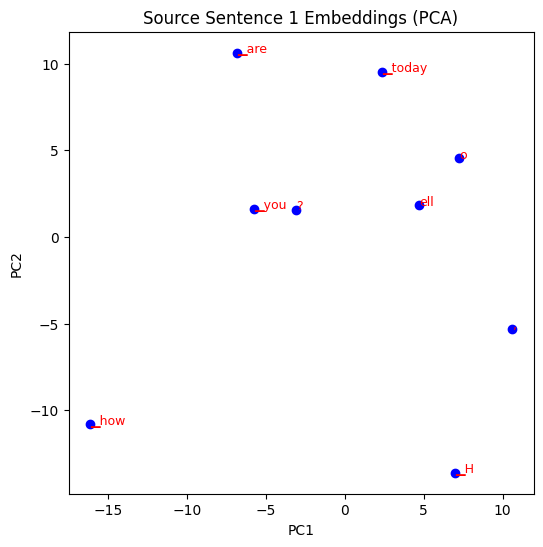

Sentence 2 | EN: This is a test to see if our model can translate English to German.
-> DE (hyp): I ch ch , daß die , daß die s , daß die , daß die s , daß die s , daß die s , daß die s n , daß die en , daß die s .



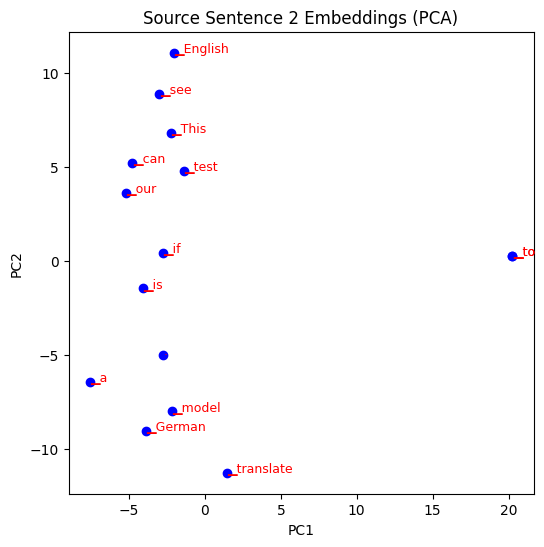

Sentence 3 | EN: The weather is nice, and I want to go outside!
-> DE (hyp): I ch ch , daß die , daß die , die , daß die , daß die , die , die n , die s , die , die s , die , die n , die , die s ,



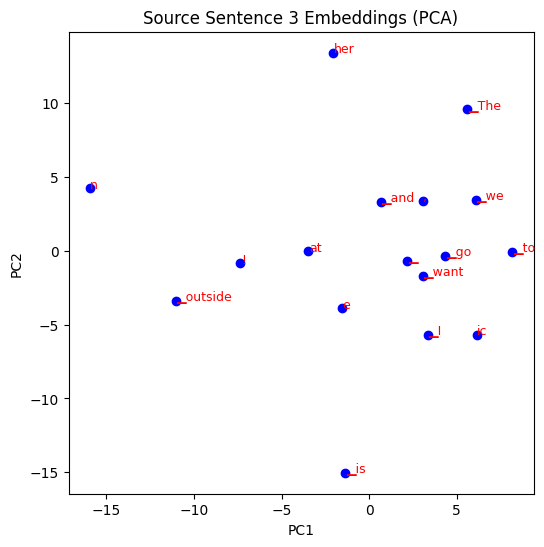

In [ ]:
import os
import yaml
import torch
import sentencepiece as spm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from src.model.transformer import Transformer
from src.evaluation.inference import generate_translation

def plot_token_embeddings(tokens, emb_2d, sentence_idx):
    plt.figure(figsize=(6, 6))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c="blue")

    for i, token in enumerate(tokens):
        x, y = emb_2d[i]
        plt.text(x + 0.02, y + 0.02, token, fontsize=9, color="red")

    plt.title(f"Source Sentence {sentence_idx + 1} Embeddings (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


def main():
    with open("config/config.yaml", "r") as f:
        cfg = yaml.safe_load(f)

    device = cfg["training"]["device"]
    sp_model = spm.SentencePieceProcessor(model_file=f"{cfg['data']['vocab_prefix']}.model")

    src_vocab_size = sp_model.vocab_size()
    tgt_vocab_size = sp_model.vocab_size()
    model = Transformer(
        src_vocab_size=src_vocab_size,
        tgt_vocab_size=tgt_vocab_size,
        d_model=cfg["model"]["d_model"],
        n_heads=cfg["model"]["n_heads"],
        num_encoder_layers=cfg["model"]["num_encoder_layers"],
        num_decoder_layers=cfg["model"]["num_decoder_layers"],
        d_ff=cfg["model"]["d_ff"],
        max_len=cfg["model"]["max_position_embeddings"],
        dropout=cfg["model"]["dropout"]
    ).to(device)

    epoch_ckpt = f"model_epoch_{cfg['training']['max_epochs']}.pt"
    ckpt_path = f"{cfg['logging']['checkpoint_dir']}/{epoch_ckpt}"
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    custom_sentences = [
        "Hello, how are you today?",
        "This is a test to see if our model can translate English to German.",
        "The weather is nice, and I want to go outside!"
    ]

    tokenized_inputs = []
    for sent in custom_sentences:
        pieces = sp_model.encode(sent, out_type=int)
        tokenized_inputs.append(pieces)

    max_len_input = max(len(x) for x in tokenized_inputs)
    pad_id = 1

    src_tensor_list = []
    for inp in tokenized_inputs:
        pad_needed = max_len_input - len(inp)
        src_tensor_list.append(inp + [pad_id] * pad_needed)
    src_tensor = torch.tensor(src_tensor_list, dtype=torch.long, device=device)

    with torch.no_grad():
        translations = generate_translation(model, src_tensor, sp_model, cfg)

    print("\n--- Inference Results ---")
    for i, (inp_ids, hyp_ids) in enumerate(zip(src_tensor_list, translations)):
        src_clean = [tid for tid in inp_ids if tid not in [pad_id, 2, 3]]
        src_text = sp_model.DecodeIds(src_clean)

        hyp_text = sp_model.DecodeIds([tid for tid in hyp_ids if tid not in [2, 3, 1]])

        print(f"Sentence {i+1} | EN: {custom_sentences[i]}")
        print(f"-> DE (hyp): {hyp_text}\n")


        with torch.no_grad():
            src_ids_tensor = torch.tensor(src_clean, device=device).unsqueeze(0)
            emb_vectors = model.src_embedding(src_ids_tensor)
            emb_vectors = emb_vectors.squeeze(0)

        pca = PCA(n_components=2)
        emb_2d = pca.fit_transform(emb_vectors.cpu().numpy())

        token_strs = sp_model.IdToPiece(src_clean)

        plot_token_embeddings(token_strs, emb_2d, i)


if __name__ == "__main__":
    main()